# Доп. задачи анализа данных
## Задание 3.4


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds20_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* При решении без доказательства можно пользоваться любыми теоретическими свойствами, которые были на лекциях или семинарах.
* Теоретические задачи необходимо оформить в LaTeX/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.


**Баллы за задание:**

* Задача 1 — 5 баллов
* Задача 2 — 15 баллов

---

## Задача 1

Рассмотрим логистическую регрессию. Пусть $x_i \in \mathbb{R}^d, Y_i \sim Bern(\mu_\theta(x_i))$. 

Мы предполагаем, что $\mu_\theta(x_i) = P_\theta(Y_i = 1)  = \sigma(x_i^T\theta)= \frac{e^{x_i^T\theta}}{1 + e^{x_i^T\theta}}$.

Регуляризацию в методе логистической регрессии можно задать с помощью введения априорного распределения на $\theta$, возьмем $\mathcal{N}(0, \alpha^{-1}I_d)$. В данном случае семейство, которому принадлежит априорное не является сопряженным семейству, которому принадлежит распределение на $Y$. Поэтому простым путем найти апостериорное распределение не получится. Однако, можно найти моду этого распределения. 

1. Выпишите соответствующую задачу оптимизации.
2. Для данной задачи:
    1. Получите формулу градиентного спуска.
    2. Получите формулу метода IRLS.

**Решение.** файл pdf прикреплён отдельно. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

sns.set_style("dark")
sns.set(font_scale=1.4)
warnings.filterwarnings('ignore')

## Задача 2

**1.** Реализуйте логистическую регрессию с регуляризацией для трех вариантов поиска оценки параметров:
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск с размером батча 5-10;
* IRLS.

Для измерения времени работы **каждого** шага используйте 

`from time import time`

*Замечания.* 

1. Для чистоты эксперимента время шага внутри цикла нужно замерять от конца предыдущего шага до конца текущего, а не от начала текущего шага.
2. Иногда при подсчете сигмоиды и оптимизируемого функционала могут возникать вычислительные ошибки. Для их избежания существуют специальные трюки.
    * [How to Evaluate the Logistic Loss and not NaN trying](http://fa.bianp.net/blog/2019/evaluate_logistic/)
    * [The log-sum-exp trick in Machine Learning](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/)
    * [Exp-normalize trick](https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)<br>
3. Трюки не обязательно реализовывать самостоятельно, можете воспользоваться функциями для них из `scipy`, `numpy`: 
    * [`scipy.special.logsumexp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html);
    * [`numpy.logaddexp`](https://numpy.org/doc/stable/reference/generated/numpy.logaddexp.html).
4. В методе IRLS можно добавить малый регуляризатор даже если регуляризации нет для исключения вычислительных проблем.

In [368]:
from time import time

class LogisticRegression():
    """
    Модель логистической регрессии. Имеет следующие гиперпараметры:
    
    * alpha: параметр регуляризации. 
             Если равно 0, то регуляризация не происходит.
    * lr: константа, на которую домножаем градиент при обучении
    * eps: ограничение на норму невязки в случае
           если используется критерий criterion='eps'
    * max_iter: ограничение на кол-во итераций в случае 
                если используется критерий criterion='max_iter'
    * method: если равно 'gd', то используется обычный градиентный спуск,
              если равно 'sgd', то используется стохастический 
                    градиентный спуск,
              если равно 'irls', то используется метод IRLS.
    * criterion: если равно 'eps', то используем ограничение 
                    на норму невязки,
                 если равно 'max_iter', то используем ограничение 
                    на количество итераций
    * fit_intercept: указывает, следует ли добавить константу в признаки
    * save_history: указывает, следует ли сохранять историю обучения
    """
    
    def __init__(self, alpha=0, lr=0.5, eps=1e-3, max_iter=1e5, 
                 method='gd', criterion='max_iter', 
                 fit_intercept=True, save_history=True):
        """Создает модель и инициализирует параметры."""
        
        criterion_error_msg = 'выбран неправильный критерий остановки'
        assert criterion in ['max_iter', 'eps'], criterion_error_msg
        
        method_error_msg = 'выбран неправильный метод'
        assert method in ['gd', 'sgd', 'irls'], method_error_msg

        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.max_iter = max_iter
        self.criterion = criterion
        self.method = method
        self.fit_intercept = fit_intercept
        self.save_history = save_history
        self.history = np.array([()])  # для хранения истории обучения
        
    @staticmethod
    def _sigmoid(x):
        return 1. / (1 + np.exp(-x))
    
    @staticmethod
    def _logsig(x):
        out = np.zeros_like(x)
        idx0 = x < -33
        out[idx0] = x[idx0]
        idx1 = (x >= -33) & (x < -18)
        out[idx1] = x[idx1] - np.exp(x[idx1])
        idx2 = (x >= -18) & (x < 37)
        out[idx2] = -np.log1p(np.exp(-x[idx2]))
        idx3 = x >= 37
        out[idx3] = -np.exp(-x[idx3])
        return out
    
    @staticmethod
    def _log_likelihood(X, Y, theta):
        z = np.dot(X, theta)
        return -np.sum((1 - Y) * z - LogisticRegression._logsig(z))

    def _add_intercept(self, X):
        """Добавляем свободный коэфициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.
        """
        
        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1)
        X_copy[:, :-1] = X

        return X_copy
    
    def _make_step_gd(self, X, Y, theta_k):
        S = LogisticRegression._sigmoid(np.dot(X, theta_k))
        return theta_k + self.lr * (np.dot(X.T, Y - S) - self.alpha * theta_k)

    def _make_step_sgd(self, X, Y, theta_k):
        S = LogisticRegression._sigmoid(np.dot(X, theta_k))
        # есть ли способ выбора оптимального размера для SGD?
        rand_inds = np.random.choice(theta_k.shape[0], size=5)
        for i in rand_inds:
            theta_k[i] += self.lr *\
            (np.dot(X.T[i], Y - S) - self.alpha * theta_k[i])
        return theta_k
    
    def _make_step_irls(self, X, Y, theta_k):
        S = LogisticRegression._sigmoid(np.dot(X, theta_k))
        V = np.diag(S * (1 - S))
        return theta_k +\
            np.linalg.inv(X.T @ V @ X +\
                          (self.alpha + 0.001) * np.eye(X.shape[1])) @\
                            (X.T @ (Y - S) - self.alpha * theta_k)
    
    def fit(self, X, Y):
        """Обучает модель логистической регресии с помощью выбранного метода,
        пока не выполнится критерий остновки self.criterion.
        Также, в случае self.save_history=True, добавляет в self.history 
        текущее значение оптимизируемого функционала 
        и время обновления коэффициентов. 
        """
        
        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        n_iters = 0
        theta_k = np.zeros(X_copy.shape[1])  # \theta_k
        self.weights = np.zeros(X_copy.shape[1])  # \theta_{k+1}
        stop = False
        dt = time() * 1e3
        self.history = np.array([[
            LogisticRegression._log_likelihood(X_copy, Y, self.weights),
            time() * 1e3 - dt
        ]])
        
        while not stop:
            theta_k = self.weights.copy()
            
            if self.method == 'gd':
                self.weights = self._make_step_gd(X_copy, Y, theta_k)
            elif self.method == 'sgd':
                self.weights = self._make_step_sgd(X_copy, Y, theta_k)
            else:
                self.weights = self._make_step_irls(X_copy, Y, theta_k)
            
            n_iters += 1
            stop = (self.criterion == 'max_iter' and n_iters > self.max_iter)\
            or (self.criterion == 'eps' and np.abs(
                LogisticRegression._log_likelihood(X_copy, Y, theta_k) -\
                LogisticRegression._log_likelihood(X_copy, Y, self.weights)
            ) < self.eps)
            self.history = np.vstack((self.history, [
                LogisticRegression._log_likelihood(
                    X_copy, Y, self.weights
                ),
                time() * 1e3 - dt
            ]))
        
        if self.fit_intercept:
            self.coef_ = self.weights[:-1]  # коэффициенты модели
            self.intercept_ = self.weights[-1]  # свободный коэффициент
        else:
            self.coef_ = self.weights  # коэффициенты модели
            self.intercept_ = 0.
            
        self.n_iter_ = n_iters  # произведенное число итераций
        
        return self

        
    def predict(self, X):
        """Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).
        
        :return: предсказание с размерностью (n_test, )
        """

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        prob_predictions = self.predict_proba(X)
        predictions = np.array(prob_predictions[:, 0] > prob_predictions[:, 1],
                              dtype = np.int)
        
        return predictions

        
    def predict_proba(self, X):
        """Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1.
        
        :return: вероятности предсказания с размерностью (n_test, 2)
        """

        if self.fit_intercept:
            theta = self.weights
            X_copy = self._add_intercept(X)
        else:
            theta = self.coef_
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        z = LogisticRegression._sigmoid(np.dot(X_copy, theta)) # вер-ть Y = 1
        prob_predictions = np.vstack((z, 1 - z)).T
        
        return prob_predictions

Рассмотрим игрушечный датасет на $30$ признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для бинарной классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [209]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')

['.. _breast_cancer_dataset:',
 '',
 'Breast cancer wisconsin (diagnostic) dataset',
 '--------------------------------------------',
 '',
 '**Data Set Characteristics:**',
 '',
 '    :Number of Instances: 569',
 '',
 '    :Number of Attributes: 30 numeric, predictive attributes and the class',
 '',
 '    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        worst/largest values) of these features w

Разделим нашу выборку на обучающую и тестовую:

In [210]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [211]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**2.** Теперь обучите три модели логистической регрессии без регуляризации с помощью методов
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск;
* IRLS.

Постройте график, на котором нанесите три кривые обучения, каждая из которых отображает зависимость оптимизируемого функционала от номера итерации метода. **Функционал должен быть одинаковый для всех моделей: логарифм правдоподобия без минусов**. Нарисуйте также график зависимости этого функционала от времени работы метода. Сделайте выводы. Что будет при обучении на датасете, в котором больше строк, а число столбцов останется прежним?

*Замечания:* 
* Все графики должны быть информативны, с подписанными осями и т.д..
* Для чистоты эксперимента желательно не запускать в момент обучения другие задачи и провести обучение несколько раз, усреднив результаты.

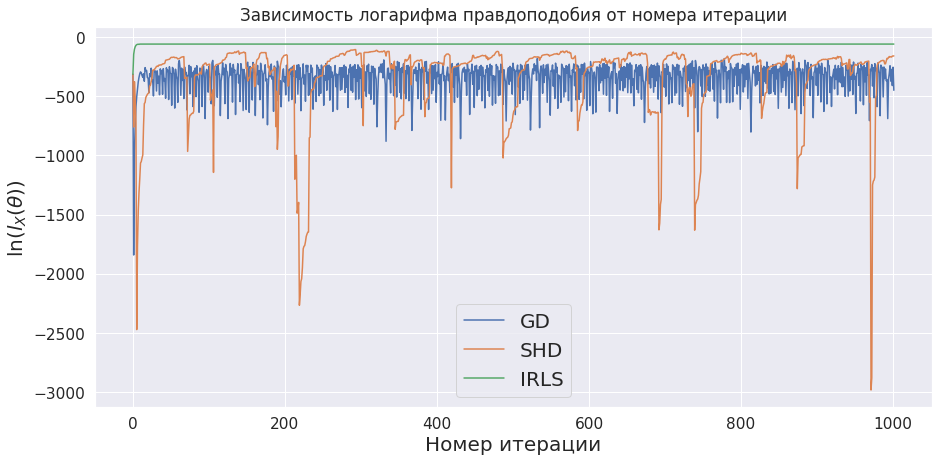

In [321]:
plt.figure(figsize=(15, 7))

model_gd = LogisticRegression(max_iter=1e3)
model_sgd = LogisticRegression(method='sgd', max_iter=1e3)
model_irls = LogisticRegression(method='irls', max_iter=1e3)

for model, label in [(model_gd, 'GD'), (model_sgd, 'SHD'),
                    (model_irls, 'IRLS')]:
    model.fit(X_train_scaled, Y_train)
    # print(model.history)
    
    plt.plot(model.history[:, 0], label=label)
    plt.title('Зависимость логарифма правдоподобия от номера итерации')
    plt.xlabel('Номер итерации', fontsize=20)
    plt.ylabel(r'$\ln(l_X(\theta))$', fontsize=20)
plt.legend(fontsize=20);

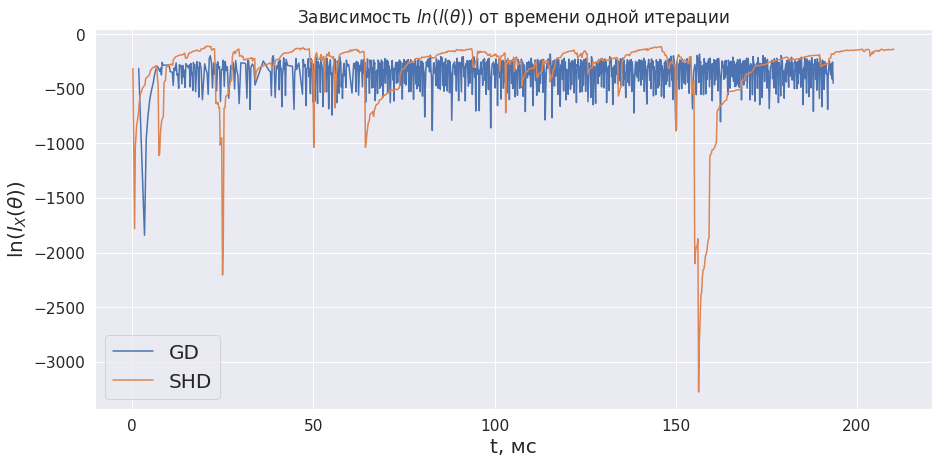

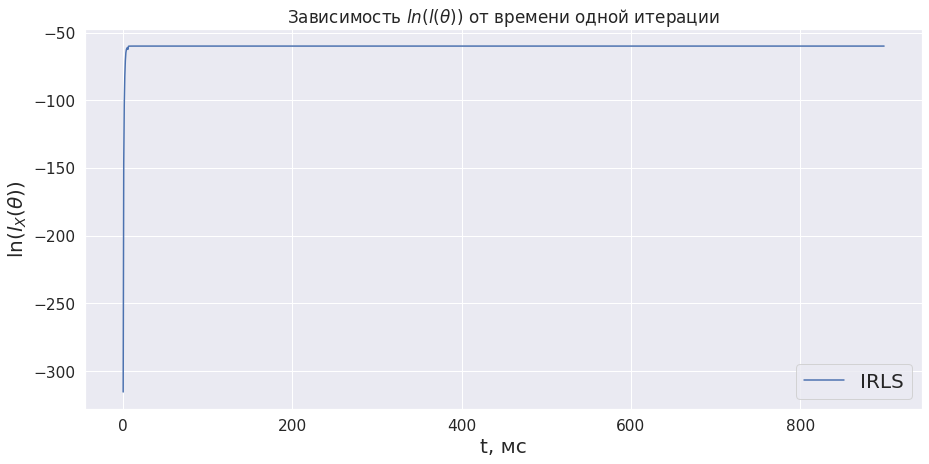

In [278]:
plt.figure(figsize=(15, 7))

model_gd = LogisticRegression(max_iter=1e3)
model_sgd = LogisticRegression(method='sgd', max_iter=1e3)
model_irls = LogisticRegression(method='irls', max_iter=1e3)

for model, label in [(model_gd, 'GD'), (model_sgd, 'SHD')]:
    model.fit(X_train_scaled, Y_train)
    # print(model.history)
    
    plt.plot(model.history[:, 1], model.history[:, 0], label=label)
    plt.title(r'Зависимость $ln(l(\theta))$ от времени одной итерации')
    plt.xlabel('t, мс', fontsize=20)
    plt.ylabel(r'$\ln(l_X(\theta))$', fontsize=20)
plt.legend(fontsize=20);

plt.figure(figsize=(15, 7))
model_irls.fit(X_train_scaled, Y_train)
# print(model.history)
    
plt.plot(model_irls.history[:, 1], model_irls.history[:, 0], label='IRLS')
plt.title(r'Зависимость $ln(l(\theta))$ от времени одной итерации')
plt.xlabel('t, мс', fontsize=20)
plt.ylabel(r'$\ln(l_X(\theta))$', fontsize=20)
plt.legend(fontsize=20);

**Вывод.** *1) Во-первых, о значениях.* При увеличении итераций (и времени тоже) значения очень быстро начинают колебаться около какого-то одного положения в методах градиентых спусков. Такие колебания связаны с тем, что шаг обучения не меняется и метод "прыгает" вокруг максимума. Причём для стохастического градиентного спуска иногда виднеются сильные изменения в значениях. Предположительно это связано с тем, что в какие-то моменты изменение одних координат в сторону роста при фиксации остальных приводит к резкому отклонению от зоны максимальных значений. Также заметим IRLS очень быстро сходится к одному значению и там и находится. Это связано с тем, что как раз в IRLS шаг обучения переменный, и мы быстро находим максимум.

*2) Во-вторых, об увеличении числа строк.* Заметим, что в лог. функции правдоподобия суммируются значения по индексу, пробегающему все строки, поэтому при увеличении числа строк сумма будет больше => во-первых, максимальное значение подвинется, во-вторых, колебания значений увеличатся. 

**3.** Сравните два реализованных критерия остановки по количеству проведенных итераций: 
* евклидова норма разности текущего и нового векторов весов стала меньше, чем $10^{-4}$;
* ограничение на число итераций (например, $10000$). 

Используйте градиентный спуск.

In [279]:
model_gd_iters = LogisticRegression(max_iter=1e4)
model_gd_norm = LogisticRegression(criterion='eps', eps=1e-4, lr=0.01)

model_gd_iters.fit(X_train_scaled, Y_train)
model_gd_norm.fit(X_train_scaled, Y_train)
print('Для критерия остановки по итерациям: разность норм --- {0:.5f}, итерации --- {1}'\
      .format(model_gd_iters.history[-1, 0] - model_gd_iters.history[-2, 0], model_gd_iters.n_iter_), '\n',
      'Для критерия остановки по норме: разность норм --- {0:.5f}, итерации --- {1}'\
      .format(model_gd_norm.history[-1, 0] - model_gd_norm.history[-2, 0], model_gd_norm.n_iter_)
     )

Для критерия остановки по итерациям: разность норм --- -316.07193, итерации --- 10001 
 Для критерия остановки по норме: разность норм --- 0.00010, итерации --- 5129


**Вывод.** Критерий по итерациям неэффективен без изменения величины шага (или просто с большим шагом), так как сильные колебания продолжатся, и число итераций ничего не будет говорить о точности. Аналогично и для критерия по точности: если мы не изменяем learning rate, то рискуем повиснуть в вечном цикле. Как Вы могли заметить, это и произошло у меня, поэтому я уменьшил lr, в итоге, на 5129 мы всё-таки достигли нужной точности.

**4.** Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Воспользуйтесь ограничением на число итераций в качестве критерия остановки, так как для больших `learning rate` у вас может не сойтись модель. Используйте стохастический градиентный спуск. Сделайте выводы.

In [281]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]
models = [
    LogisticRegression(lr = lrs[i], max_iter=1e3) for i in range(len(lrs))
]
for i in range(len(lrs)):
    models[i].fit(X_train_scaled, Y_train)

Постройте кривые обучения для различных `learning rate`. Не обязательно рассматривать все `learning rate` из предыдущего задания, так как их слишком много, и график будет нагроможден. Возьмите около половины из них. Какой `learning rate` лучше выбрать? Чем плохи маленькие и большие `learning rate`?

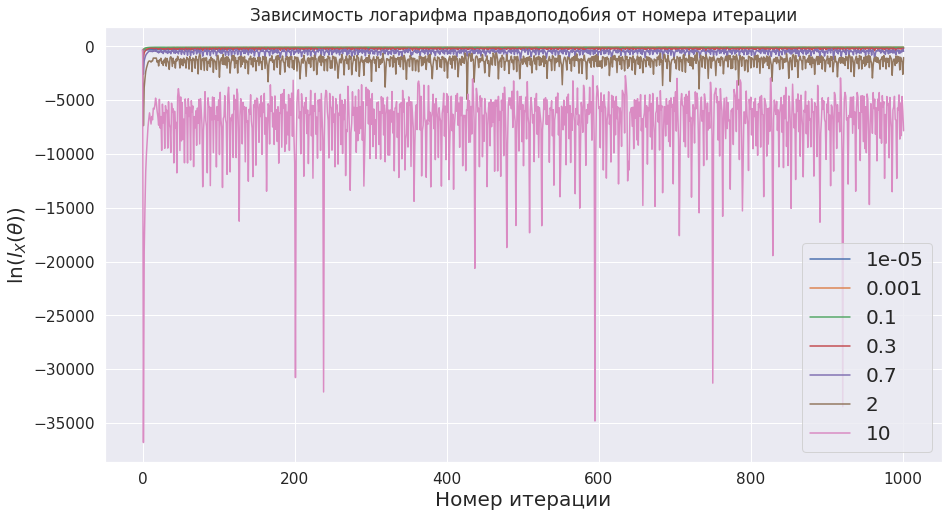

In [287]:
plt.figure(figsize=(15, 8))
for i in range(0, len(lrs), 2):
    plt.plot(models[i].history[:, 0], label=lrs[i])
    plt.title('Зависимость логарифма правдоподобия от номера итерации')
    plt.xlabel('Номер итерации', fontsize=20)
    plt.ylabel(r'$\ln(l_X(\theta))$', fontsize=20)
plt.legend(fontsize=20);

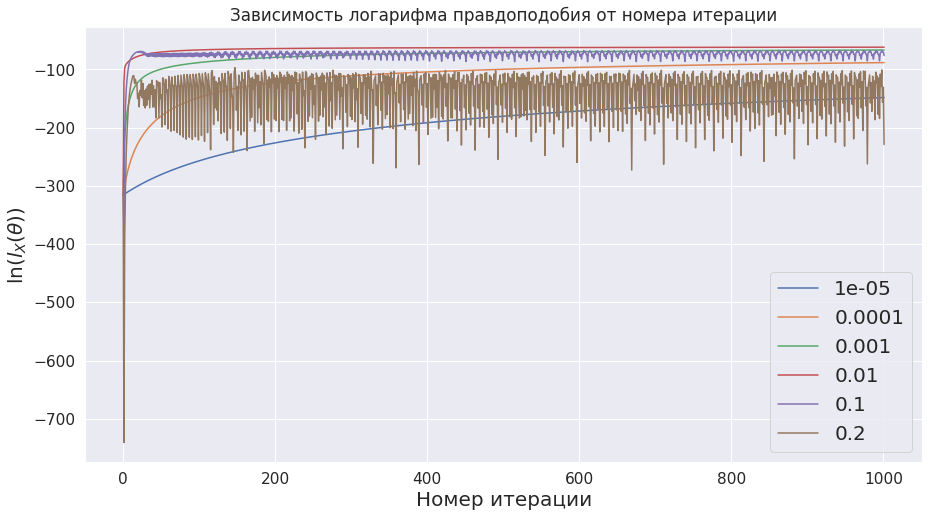

In [293]:
plt.figure(figsize=(15, 8))

for i in range(0, len(lrs) // 2):
    plt.plot(models[i].history[:, 0], label=lrs[i])
    plt.title('Зависимость логарифма правдоподобия от номера итерации')
    plt.xlabel('Номер итерации', fontsize=20)
    plt.ylabel(r'$\ln(l_X(\theta))$', fontsize=20)
plt.legend(fontsize=20);

**Вывод.** При больших learning rate (больше 0.7) изменения очень большие и получаются очень большие скачки в значениях. Более того, в среднем значения тоже сдвигаются вниз, так как при бОльших lr мы сильнее перепрыгиваем через максимум. В очень маленьком lr плохо обычно то, что резко увеличивается число итераций до достижения максимума.

**5.** Рассмотрите несколько моделей с оптимизацией при помощи GD, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество, сделайте выводы. Под качеством подразумевается значение какой-либо выбранной вами метрики качества классификации.

In [351]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score)

alphas = [0., 1e-2, 1e-1, 1., 4.]
models = [
    LogisticRegression(alpha = alphas[i], max_iter=1e3)\
    for i in range(len(alphas))
]
for i in range(len(alphas)):
    models[i].fit(X_train_scaled, Y_train)
    
    roc_auc = roc_auc_score(
        Y_test, models[i].predict_proba(X_test_scaled)[:, 0]
    )
    print(f'Для модели с alpha = {alphas[i]}:\nAUC-ROC = {roc_auc:.3f}')
    precision = precision_score(Y_test, models[i].predict(X_test_scaled))
    print(f'Precision = {precision:.3f}')
    recall = recall_score(Y_test, models[i].predict(X_test_scaled))
    print(f'Recall = {precision:.3f}')
    accuracy = accuracy_score(Y_test, models[i].predict(X_test_scaled))
    print(f'Accuracy = {recall:.3f}\n=======================================')

Для модели с alpha = 0.0:
AUC-ROC = 0.935
Precision = 0.845
Recall = 0.845
Accuracy = 1.000
Для модели с alpha = 0.01:
AUC-ROC = 0.975
Precision = 0.938
Recall = 0.938
Accuracy = 0.859
Для модели с alpha = 0.1:
AUC-ROC = 0.954
Precision = 0.886
Recall = 0.886
Accuracy = 0.986
Для модели с alpha = 1.0:
AUC-ROC = 0.969
Precision = 1.000
Recall = 1.000
Accuracy = 0.676
Для модели с alpha = 4.0:
AUC-ROC = 0.839
Precision = 0.906
Recall = 0.906
Accuracy = 0.817


**6.** Возьмите лучшую модель с предыдущего шага. В исходной выборке оставьте только два произвольных признака и обучите на них модель без использования свободного параметра. Визуализируйте предсказания вероятностей класса $1$ для модели.

In [360]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 4), 
                               np.linspace(-10, 10, 4))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 4*4)).T
print([x0_grid, x1_grid], '\n', '\n', ravel_grid)

[array([[-10.        ,  -3.33333333,   3.33333333,  10.        ],
       [-10.        ,  -3.33333333,   3.33333333,  10.        ],
       [-10.        ,  -3.33333333,   3.33333333,  10.        ],
       [-10.        ,  -3.33333333,   3.33333333,  10.        ]]), array([[-10.        , -10.        , -10.        , -10.        ],
       [ -3.33333333,  -3.33333333,  -3.33333333,  -3.33333333],
       [  3.33333333,   3.33333333,   3.33333333,   3.33333333],
       [ 10.        ,  10.        ,  10.        ,  10.        ]])] 
 
 [[-10.         -10.        ]
 [ -3.33333333 -10.        ]
 [  3.33333333 -10.        ]
 [ 10.         -10.        ]
 [-10.          -3.33333333]
 [ -3.33333333  -3.33333333]
 [  3.33333333  -3.33333333]
 [ 10.          -3.33333333]
 [-10.           3.33333333]
 [ -3.33333333   3.33333333]
 [  3.33333333   3.33333333]
 [ 10.           3.33333333]
 [-10.          10.        ]
 [ -3.33333333  10.        ]
 [  3.33333333  10.        ]
 [ 10.          10.        ]]


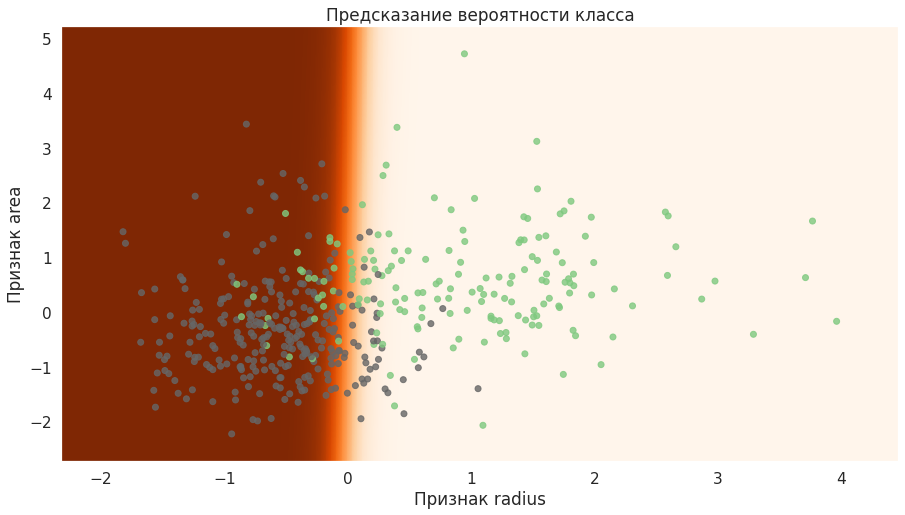

In [373]:
best_model = LogisticRegression(alpha=1.0, max_iter=1e3, fit_intercept=False)
new_X_train_scaled = np.vstack((X_train_scaled[:, 0], X_train_scaled[:, 1])).T
best_model.fit(new_X_train_scaled, Y_train)


x1_min, x1_max = new_X_train_scaled[:, 0].min() - 0.5,\
                    new_X_train_scaled[:, 0].max() + 0.5
x2_min, x2_max = new_X_train_scaled[:, 1].min() - 0.5,\
                    new_X_train_scaled[:, 1].max() + 0.5

x0_grid, x1_grid = np.meshgrid(np.linspace(x1_min, x1_max, 1000), 
                               np.linspace(x2_min, x2_max, 1000))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 1000 * 1000)).T
prob_grid = best_model.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((1000, 1000))


plt.figure(figsize=(15, 8))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(new_X_train_scaled[:, 0], new_X_train_scaled[:, 1], c=Y_train,
            alpha=0.8, cmap='Accent')
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.xlabel('Признак radius'), plt.ylabel('Признак area')
plt.title('Предсказание вероятности класса');

**Вывод.** Урааа, после долгих часов мучений логистическая регрессия научилась неплохо разделять классы.